# Figure 2 (PDB baseline panels)

The code below has been used to create Figure 2a, 2c and 2e (PDB baseline) in [the main paper](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2) as well as Figures S66, S67, S69 and S70 in the [supplement](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2.supplementary-material). 

Contact: pawel.szczerbiak@uj.edu.pl or p.szczerbiak@gmail.com

Before running other cells, run the commands below in the terminal and activate the  `<env_name>` kernel in this notebook:

`conda create -n <env_name> numpy scikit-learn seaborn ipykernel`  
`conda activate <env_name>`  
`ipython kernel install --user --name=<env_name>`

Alternatively, one can use `virtualenv` instead of `conda` package manager.

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.metrics.pairwise import pairwise_distances

## Global paths

**NOTE:** change the paths below appropriately.  
The first one should point to the `intermediate_data` folder downloded from the [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs) website.

In [2]:
MAIN_DIR = Path('/path/to/intermediate_data/')
OUT_DIR = Path('./')  # current notebook directory

## Data generation

### All-against-all comparisons

See `pairwise_comparisons/tmalign/`

#### Notes

- all quantities were computed using `TMalign` (see the paper for details)
- computations were performed in a pairwise manner without duplicates (upper triangular matrix)

#### Columns description
- `MIP name 1` - ID of the first compared PDB 
- `MIP name 2` - ID of the second compared PDB  
- `MIP length 1` - length of the first compared PDB [aa]  
- `MIP length 2` - length of the second compared PDB [aa] 
- `Alignment length` - number of aligned residues [aa]
- `Sequence identity`
- `RMSD` - root-mean-square deviation
- `TM-score 1`- TM-score normalized by the first PDB length
- `TM-score 2`- TM-score normalized by the second PDB length
- `TM-score mean` - $\rm (TM_{score\;1} + TM_{score\;2})\;/\;2$ 
- `TM-score max` - $\rm max (TM_{score\;1}, TM_{score\;2})$ 

### DeepFRI predictions

See `pairwise_comparisons/deepfri/`

DeepFRI predictions were generated in the same way as the MIP curated predictions (see the paper for details).

## Load data

### All-against-all comparisons

In [3]:
perc10_m2m  =  pickle.load(open(MAIN_DIR / 'pairwise_comparisons' / 'tmalign' / 'pdb_baseline_10perc_m2m_full.pkl', 'rb'))
perc20_m2m  =  pickle.load(open(MAIN_DIR / 'pairwise_comparisons' / 'tmalign' / 'pdb_baseline_20perc_m2m_full.pkl', 'rb'))

### DeepFRI predictions

In [4]:
perc10_deepfri, perc20_deepfri = {}, {}
keys = ["BP", "CC", "MF", "EC"]
for key in keys:
    perc10_deepfri[key] = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'deepfri' / f'pdb_baseline_10perc_{key}.csv', index_col=0)
    perc20_deepfri[key] = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'deepfri' / f'pdb_baseline_20perc_{key}.csv', index_col=0)

#### Check if PDB IDs agree among all groups

In [5]:
for key_1 in keys:
    for key_2 in keys:
        assert perc10_deepfri[key_1].index.equals(perc10_deepfri[key_2].index)
        assert perc20_deepfri[key_1].index.equals(perc20_deepfri[key_2].index)       

#### Create prediction arrays

In [6]:
perc10_deepfri_arr = np.hstack([perc10_deepfri[key].values for key in keys])
perc20_deepfri_arr = np.hstack([perc20_deepfri[key].values for key in keys])

## Calculate function similarities

### Sort DeepFRI predictions

In [7]:
perc10_ind = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'indices' / 'pdb_baseline_10perc.txt', header=None).values[:,0]
perc20_ind = pd.read_csv(MAIN_DIR / 'pairwise_comparisons' / 'indices' / 'pdb_baseline_20perc.txt', header=None).values[:,0]

In [8]:
# DeepFRI prediction indices (any key may be chosen)
perc10_deepfri_ind = perc10_deepfri['EC'].index
perc20_deepfri_ind = perc20_deepfri['EC'].index
# Sort the DeepFRI output according to the m2m dataframe
perc10_deepfri_order_dict = dict(zip(perc10_deepfri_ind, range(len(perc10_deepfri_ind))))
perc20_deepfri_order_dict = dict(zip(perc20_deepfri_ind, range(len(perc20_deepfri_ind))))
perc10_deepfri_ind_sorted = [perc10_deepfri_order_dict[el] for el in perc10_ind]
perc20_deepfri_ind_sorted = [perc20_deepfri_order_dict[el] for el in perc20_ind]
perc10_deepfri_arr_sorted = perc10_deepfri_arr[perc10_deepfri_ind_sorted]
perc20_deepfri_arr_sorted = perc20_deepfri_arr[perc20_deepfri_ind_sorted]

In [9]:
def calc_m2m_attr(mat, metric='cosine', out_order=None):
    """
    'mat' is of shape: nxm
        'n' - number of samples
        'm' - number of features
    'out_order' is the order for output indices
    """
    # Compute distance matrix
    result = pairwise_distances(mat, metric=metric)
    # Discard lower triangle and main diagonal
    result[np.tril_indices(len(result))] = np.nan
    # Sort the output triangular matrix
    result = result[out_order]
    # Remove nans
    result = result[~np.isnan(result)]
    return result

### Add cosine similarity between DeepFRI vectors to the pairwise dataframes

In [10]:
thr = 0.1  # used for denoising
perc10_m2m["DeepFRI GCN cossim denoised"] = 1 - calc_m2m_attr(np.where(perc10_deepfri_arr_sorted>=thr, 
                                               perc10_deepfri_arr_sorted, 0))
perc20_m2m["DeepFRI GCN cossim denoised"] = 1 - calc_m2m_attr(np.where(perc20_deepfri_arr_sorted>=thr, 
                                               perc20_deepfri_arr_sorted, 0))

### Sanity check

Check results manually

In [11]:
# 10perc
label1 = '1TRNA'
label2 = '5MFOA'
ind1_deepfri = np.argwhere(perc10_deepfri_ind == label1)[0][0]
ind2_deepfri = np.argwhere(perc10_deepfri_ind == label2)[0][0]
# without sorting
t1 = np.where(perc10_deepfri_arr[ind1_deepfri]>=thr, perc10_deepfri_arr[ind1_deepfri], 0)
t2 = np.where(perc10_deepfri_arr[ind2_deepfri]>=thr, perc10_deepfri_arr[ind2_deepfri], 0)
manual = 1 - pairwise_distances(np.array([t1, t2]), metric='cosine')[0, 1]
assert manual == perc10_m2m[(perc10_m2m['MIP name 1'] == label1) & \
            (perc10_m2m['MIP name 2'] == label2)]['DeepFRI GCN cossim denoised'].values[0]
# 20perc
label1 = '7KQOB'
label2 = '7KR0A'
ind1_deepfri = np.argwhere(perc20_deepfri_ind == label1)[0][0]
ind2_deepfri = np.argwhere(perc20_deepfri_ind == label2)[0][0]
# without sorting
t1 = np.where(perc20_deepfri_arr[ind1_deepfri]>=thr, perc20_deepfri_arr[ind1_deepfri], 0)
t2 = np.where(perc20_deepfri_arr[ind2_deepfri]>=thr, perc20_deepfri_arr[ind2_deepfri], 0)
manual = 1 - pairwise_distances(np.array([t1, t2]), metric='cosine')[0, 1]
assert manual == perc20_m2m[(perc20_m2m['MIP name 1'] == label1) & \
            (perc20_m2m['MIP name 2'] == label2)]['DeepFRI GCN cossim denoised'].values[0]

## Plots

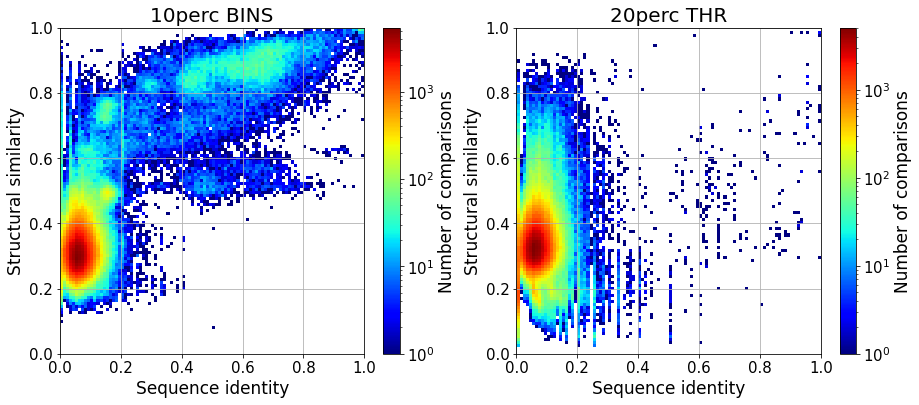

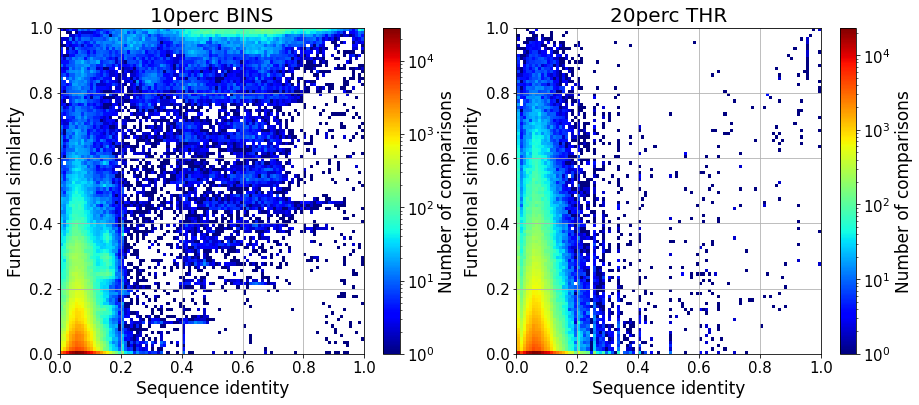

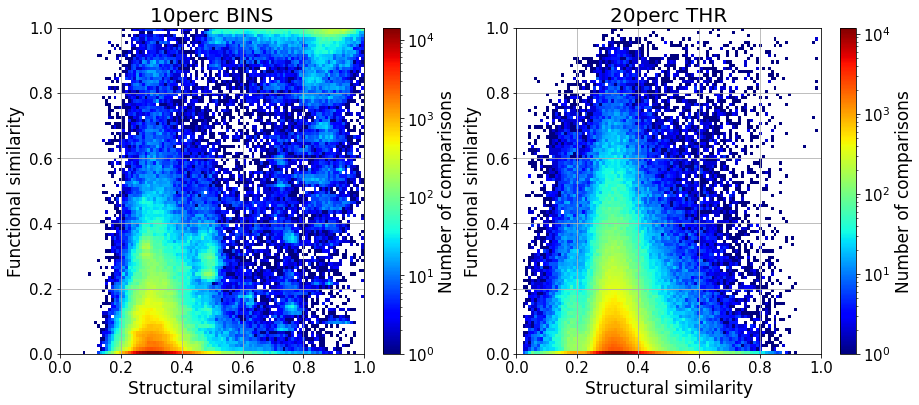

In [47]:
params = [{'cols': ["Sequence identity",  "TM-score max"], 
          'xylabels': ["Sequence identity", "Structural similarity"]},
          {'cols': ["Sequence identity",  "DeepFRI GCN cossim denoised"], 
          'xylabels': ["Sequence identity", "Functional similarity"]},
          {'cols': ["TM-score max", "DeepFRI GCN cossim denoised"], 
          'xylabels': ["Structural similarity", "Functional similarity"]}]

dfs = [perc10_m2m, perc20_m2m]
labels = ["10perc BINS", "20perc THR"]

for par in params:
    plt.figure(figsize = (15, 6))
    for i, df in enumerate(dfs):
        plt.subplot(1, 2, i + 1)
        data = df[par['cols']].values 
        plt.hist2d(data[:, 0], data[:, 1], (100, 100), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
        cbar=plt.colorbar()
        cbar.ax.set_ylabel('Number of comparisons', fontsize=17)
        cbar.ax.tick_params(axis='both', which='major', labelsize=15)
        plt.title(labels[i], fontsize=20)
        plt.xlabel(par['xylabels'][0], fontsize=17)
        plt.ylabel(par['xylabels'][1], fontsize=17)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.grid(True)
        par_str_1 = par['xylabels'][0].lower().replace(' ', '-')
        par_str_2 = par['xylabels'][1].lower().replace(' ', '-')
        # Save figure
        plt.savefig(OUT_DIR / f'Figure_2_PDB-baseline_{par_str_1}_vs_{par_str_2}.png', 
                    bbox_inches = 'tight', dpi=400)        
        # Save data
        df[par['cols'] + ['MIP name 1', 'MIP name 2']].to_csv(
            OUT_DIR / f'Figure_2_PDB-baseline_{par_str_1}_vs_{par_str_2}.csv',
            header=[par['xylabels'][0], par['xylabels'][1], 'PDB ID 1', 'PDB ID 2'], index=False)
    plt.show()

## Figure S66

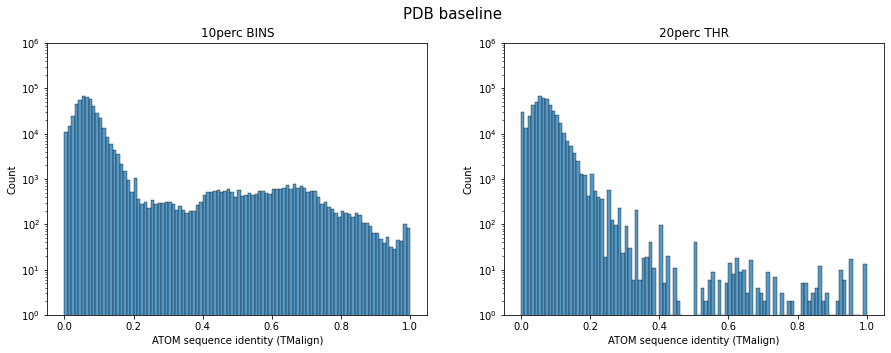

In [13]:
dfs = [perc10_m2m, perc20_m2m]
labels = ["10perc BINS", "20perc THR"]

plt.figure(figsize = (15, 5))
for i, df in enumerate(dfs):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df['Sequence identity'], bins=100)
    plt.title(labels[i])
    plt.yscale('log')
    plt.xlabel('ATOM sequence identity (TMalign)')
    plt.ylim([1, 1e6])
    plt.suptitle('PDB baseline', fontsize=15)
plt.show()

## Figure S69 and S70
Consider different sequence identity bins

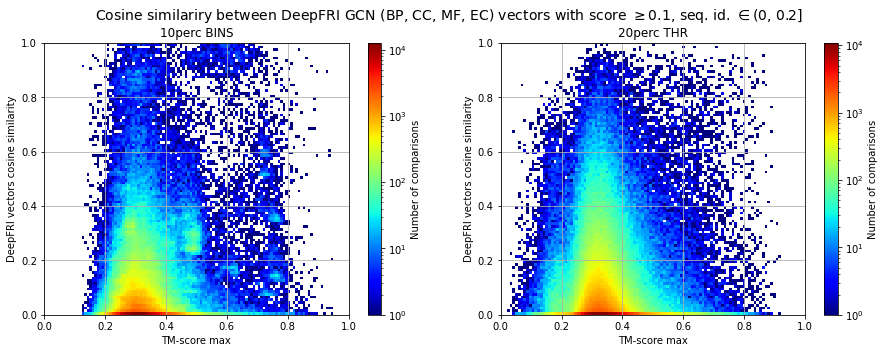

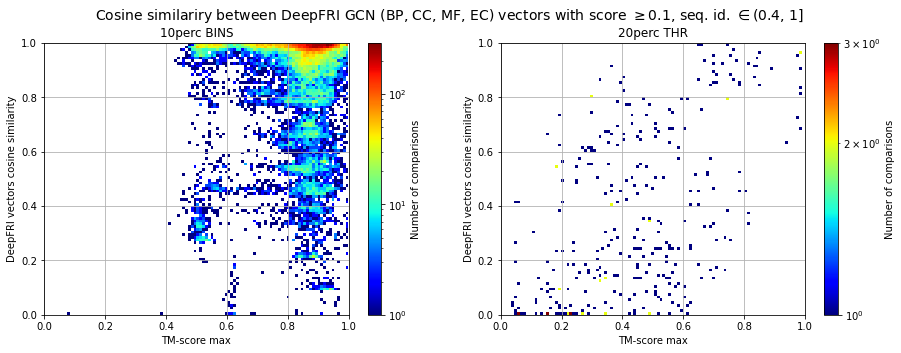

In [14]:
for sim_A, sim_B in [(0, 0.2), (0.4, 1)]:
    dfs = [
        perc10_m2m.query(f"{sim_A} < `Sequence identity` <= {sim_B}"), 
        perc20_m2m.query(f"{sim_A} < `Sequence identity` <= {sim_B}")
    ]
    plt.figure(figsize = (15, 5))
    for i, df in enumerate(dfs):
        plt.subplot(1, 2, i + 1)
        plt.hist2d(df['TM-score max'], df['DeepFRI GCN cossim denoised'], 
                   (100, 100), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
        cbar=plt.colorbar()
        cbar.ax.set_ylabel('Number of comparisons')
        plt.title(labels[i])
        plt.xlabel('TM-score max')
        plt.ylabel('DeepFRI vectors cosine similarity')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.grid(True)
    plt.suptitle(f'Cosine similariry between DeepFRI GCN (BP, CC, MF, EC) '
                 r"vectors with score $\geq$" +  str(thr) +
                 r", seq. id. $\in$" + f"({sim_A}, {sim_B}]", fontsize=14)
    plt.show()